In [1]:
#Basic
import pandas as pd
import numpy as np
#Math
import scipy as sp
from random import randint
from math import exp
import operator

#Scraping
import requests
import json

#Youtube Data API Packages: 
from apiclient.discovery import build
from apiclient.errors import HttpError
from oauth2client.tools import argparser
from googleapiclient.discovery import build
import argparse
"""
from googleapiclient.errors import HttpError"""

#Modeling
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
#from sklearn.linear_model import LogisticRegression
#from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
#from sklearn.cluster import KMeans
#from sklearn.svm import SVC
#from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

#NLP & Text Management
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.stem import PorterStemmer

#Time analysis
import time
import datetime as dt
"""from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf"""

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
#from wordcloud import WordCloud

%matplotlib inline
plt.style.use('seaborn-whitegrid')
sns.set_style('whitegrid')

In [2]:
df_main = pd.read_csv('./data/clean_data_nocomments_noviews_02.10.18.csv')

#create log features
df_main['view_log'] = df_main['viewCount'].map(lambda x: 0 if x==0 else np.log10(x)) #Which log to use???
df_main['comment_log'] = df_main['commentCount'].map(lambda x: 0 if x==0 else np.log10(x))
df_main['like_log'] = df_main['likeCount'].map(lambda x: 0 if x==0 else np.log10(x))
df_main['dislike_log'] = df_main['dislikeCount'].map(lambda x: 0 if x==0 else np.log10(x))

df_main.publishedAt = pd.to_datetime(df_main.publishedAt)
df_main['week'] = df_main.publishedAt.map(lambda x: x.week)

df_main.description.fillna('', inplace=True)

df_main.tags.fillna('', inplace=True)

Run_Text_Analysis = False

In [3]:
df_main.columns

Index(['caption', 'channelTitle', 'commentCount', 'defaultLanguage',
       'definition', 'description', 'dislikeCount', 'duration',
       'favoriteCount', 'licensedContent', 'likeCount', 'publishedAt',
       'regionRestriction', 'tags', 'title', 'vidId', 'viewCount',
       'request_token', 'letter_search', 'contentRating', 'year', 'month',
       'month_day', 'year_day', 'week_day', 'view_log', 'week'],
      dtype='object')

In [4]:
df_main.shape

(8694, 27)

In [5]:
print('   mean: ', df_main.viewCount.mean())
print('   median: ', df_main.viewCount.median())
print('   mode: ', df_main.viewCount.mode())

   mean:  53227002.69358178
   median:  3362238.5
   mode:  0    0
dtype: int64


In [6]:
#How skewed are we?
df_main.viewCount.mean() /  df_main.viewCount.median()

15.830823034588946

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


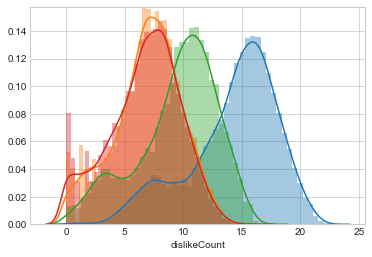

In [7]:
sns.distplot(np.log(df_main[df_main.viewCount>0].viewCount)) #Views
sns.distplot(np.log(df_main[df_main.commentCount>0].commentCount)) #Comments
sns.distplot(np.log(df_main[df_main.likeCount>0].likeCount)) #Likes
sns.distplot(np.log(df_main[df_main.dislikeCount>0].dislikeCount)) #dislikes -- very similar to comments 

In [8]:
#Engagement
print('   comment ratio', (df_main.commentCount / df_main.viewCount).median())
print('   dislike ratio', (df_main.dislikeCount / df_main.viewCount).median())
print('   like ratio', (df_main.likeCount / df_main.viewCount).median())

   comment ratio 0.00034203926675335035
   dislike ratio 0.00022929015398251337
   like ratio 0.006713840631370753


In [34]:
def get_col_mode(df,col_name):
    df=df
    col_name = col_name
    series_vals = df[col_name]
    _temp_dict = {}
    _temp_step = round(max(series_vals) / 200, 3)
    #Start at 2 to avoid 0s
    for i in range(9, 200):
        _min = i*_temp_step
        _max = (i+1)*_temp_step
        _temp_dict[_max] = df[(df[col_name] >=_min)& (df[col_name]<_max)].shape[0]
    return [k for k in _temp_dict.keys() if _temp_dict[k]==max(_temp_dict.values())][0], _temp_dict

In [35]:
comment_mode = get_col_mode(df_main,'comment_log')[0]
dislike_mode = get_col_mode(df_main,'dislike_log')[0]
view_mode = get_col_mode(df_main,'view_log')[0]
like_mode = get_col_mode(df_main,'like_log')[0]

In [36]:
comment_mode

3.128

In [37]:
dislike_mode

2.9400000000000004

In [38]:
view_mode

6.958

In [39]:
like_mode

4.403

In [40]:
(df_main[(df_main.view_log >= 7)&(df_main.view_log<10)]['likeCount'] / df_main[(df_main.view_log >= 7)&(df_main.view_log<10)]['viewCount']).median()

0.005501803737486802

In [41]:
view_bins = get_col_mode(df_main,'like_log')[1]
view_bins

{0.37: 0,
 0.407: 0,
 0.44399999999999995: 0,
 0.481: 42,
 0.518: 0,
 0.5549999999999999: 0,
 0.592: 0,
 0.629: 40,
 0.6659999999999999: 0,
 0.703: 32,
 0.74: 0,
 0.7769999999999999: 0,
 0.814: 31,
 0.851: 33,
 0.8879999999999999: 0,
 0.9249999999999999: 19,
 0.962: 24,
 0.999: 0,
 1.036: 33,
 1.073: 34,
 1.1099999999999999: 20,
 1.147: 41,
 1.184: 21,
 1.2209999999999999: 17,
 1.258: 37,
 1.295: 21,
 1.3319999999999999: 27,
 1.369: 30,
 1.406: 22,
 1.4429999999999998: 31,
 1.48: 29,
 1.517: 20,
 1.5539999999999998: 27,
 1.591: 34,
 1.628: 40,
 1.6649999999999998: 31,
 1.702: 26,
 1.7389999999999999: 24,
 1.7759999999999998: 15,
 1.813: 29,
 1.8499999999999999: 22,
 1.887: 28,
 1.924: 20,
 1.9609999999999999: 20,
 1.998: 22,
 2.0349999999999997: 33,
 2.072: 22,
 2.109: 31,
 2.146: 15,
 2.183: 28,
 2.2199999999999998: 20,
 2.2569999999999997: 18,
 2.294: 27,
 2.331: 28,
 2.368: 23,
 2.405: 27,
 2.4419999999999997: 22,
 2.479: 23,
 2.516: 26,
 2.553: 31,
 2.59: 21,
 2.627: 21,
 2.6639999

## Duration

In [9]:
#How many of these are over 20 minutes? A lot. 
df_main[df_main.duration>(20*60)].shape[0] / df_main.shape[0]

0.06970324361628709

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


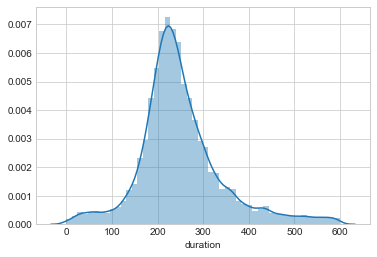

In [10]:
sns.distplot((df_main[df_main.duration<(10*60)].duration))

In [11]:
#Are they interesting?
df_main[df_main.duration>(20*60)]['viewCount'].max()

182653201

In [12]:
# A lot of relaxation stuff here. 
df_main[(df_main.duration>(20*60))&(df_main.viewCount>10000000)].loc[:, ['description', 'title', 'viewCount']]

,description,title,viewCount
38,The extended version of Clair de Lune. \r\r\n\...,Clair de Lune (Extended),21055960
481,Relaxdaily's instrumental background music: sl...,Background Music Instrumentals - relaxdaily - ...,76793517
562,3 hours of beautiful music (tracklist below) b...,3 Hours of Beautiful Music by Peder B. Helland,15990378
661,Subscribe for more classical music: http://bi...,The Best of Beethoven,31932211
1155,Pachelbel's Canon aka Canon in D is the name c...,Canon In D | Pachelbel's Canon | 1 Hour Version,19945987
1325,"Live At the Grand Rex, Paris April 2004, Cesar...",Cesaria Evora Live D'amor 2004 (Complete Concert),16876744
1344,Wolfgang Amadeus Mozart: Requiem in D minor (...,Mozart - Requiem in D minor (Complete/Full) [HD],34548812
1416,The clock is ticking and the world awaits... W...,I’d do it all | BTS: Burn the Stage Ep1,16584409
1547,Música relaxante para acalmar a mente e relaxa...,Música Relaxante - Acalmar a Mente e Relaxar,22912330
1706,★ QUER COLABORAR COM O NOSSO TRABALHO? Doe R$1...,"Música Anti-Depressão e Ansiedade, Equilibrio ...",23586767


## Text Stuff

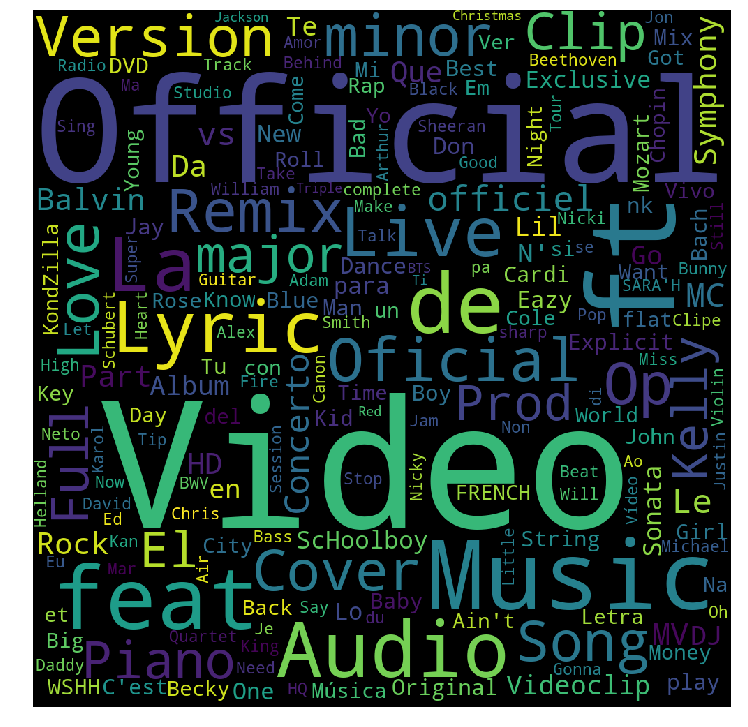

In [13]:
#Title Words
corpus_string1 = ''
for i in range(df_main.shape[0]):
    corpus_string1 = corpus_string1 + df_main.iloc[i]['title']

mycloud_2 = WordCloud(width=1000, height=1000,
                    collocations=False, #get rid of duplicates
                   normalize_plurals=True).generate_from_text(corpus_string1)
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(mycloud_2)
plt.axis("off")
plt.tight_layout(pad = 0)

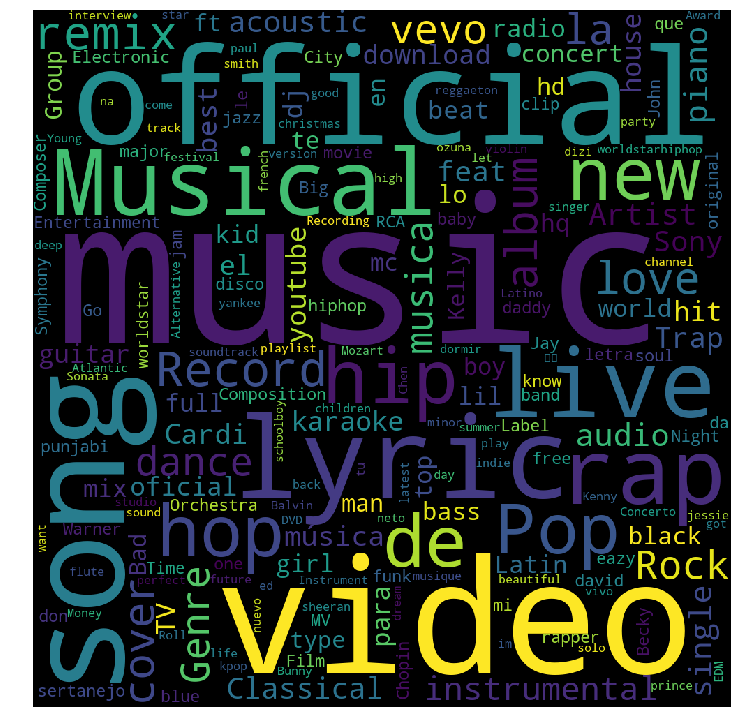

In [14]:
#Tags
corpus_string2 = ''
for i in range(df_main.shape[0]):
    corpus_string2 = corpus_string2 + str(df_main.iloc[i]['tags'])

mycloud_2 = WordCloud(width=1000, height=1000,
                    collocations=False, #get rid of duplicates
                   normalize_plurals=True).generate_from_text(corpus_string2)
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(mycloud_2)
plt.axis("off")
plt.tight_layout(pad = 0)

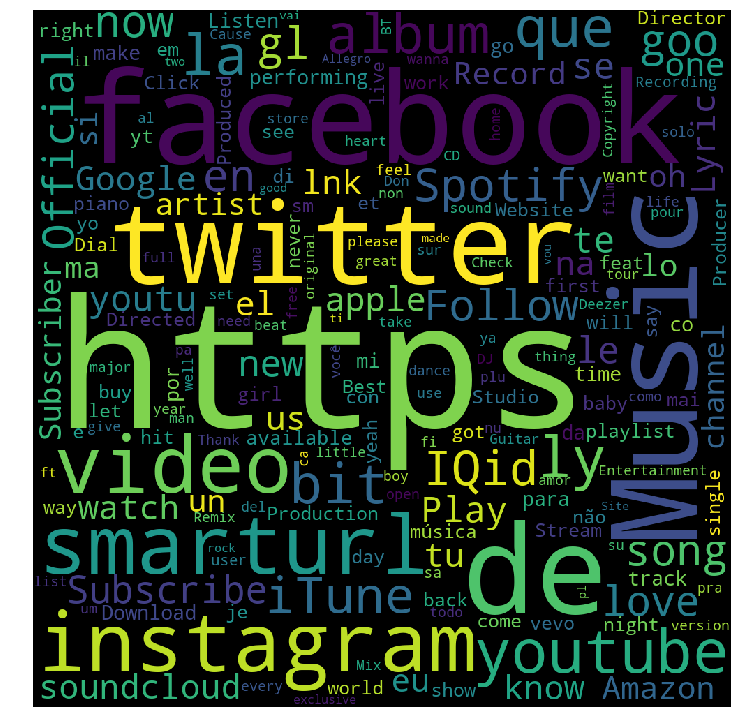

In [15]:
#Description
corpus_string3 = ''
for i in range(df_main.shape[0]):
    corpus_string3 = corpus_string3 + str(df_main.iloc[i]['description'])

mycloud_2 = WordCloud(width=1000, height=1000,
                    collocations=False, #get rid of duplicates
                   normalize_plurals=True).generate_from_text(corpus_string3)
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(mycloud_2)
plt.axis("off")
plt.tight_layout(pad = 0)

## Sentiment

In [17]:
TextBlob(corpus_string1).sentiment.polarity #Title

0.1242649255397477

In [18]:
TextBlob(corpus_string2).sentiment.polarity #Tags

0.11938258688631741

In [19]:
TextBlob(corpus_string3).sentiment.polarity #Description

0.18659575052243543

## Time Series

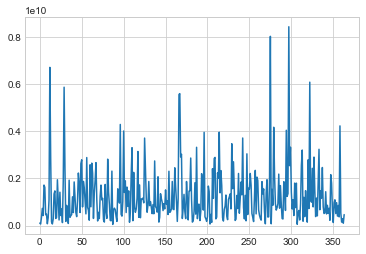

In [20]:
plt.plot([df_main[(df_main['year_day']==i)]['viewCount'].sum() for i in range(1,365)])

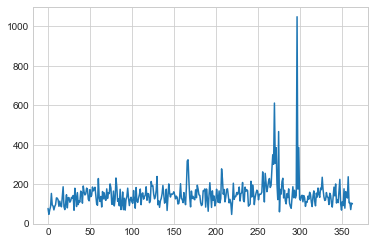

In [21]:
plt.plot([df_main[df_main['year_day']==i]['view_log'].sum() for i in range(1,365)])

In [22]:
year_day_view_list = [df_main[df_main['year_day']==i]['view_log'].sum() for i in range(1,365)]
year_day_view_list.index(max(year_day_view_list))

297

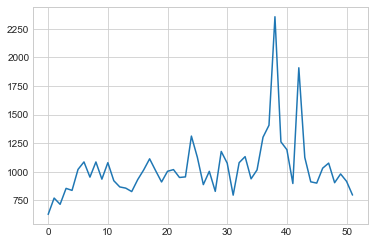

In [23]:
plt.plot([df_main[df_main['week']==i]['view_log'].sum() for i in range(1,53)])

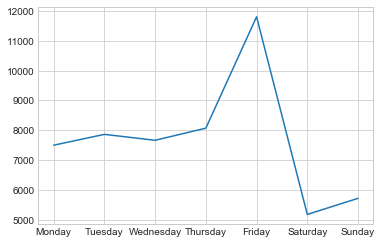

In [24]:
plt.plot(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], [df_main[df_main['week_day']==i]['view_log'].sum() for i in range(0,7)])

In [25]:
#Weekend releases:
df_main[df_main['week_day']==5]['view_log'].shape[0] + df_main[df_main['week_day']==6]['view_log'].shape[0]

1833

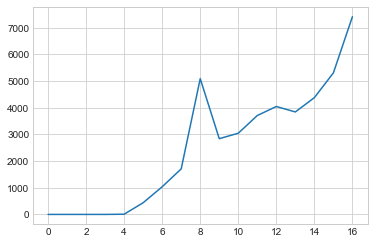

In [26]:
plt.plot([df_main[df_main['year']==i]['view_log'].sum() for i in range(1,18)])

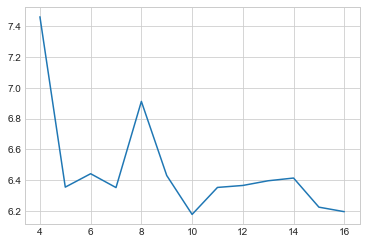

In [27]:
plt.plot([df_main[df_main['year']==i]['view_log'].mean() for i in range(1,18)])
#Something to note - only old videos with heaps of views are stil included in the most relevant search.
#2008 is the Golden Era of Youtube Music Videos


# After Feature Engineering Round

In [48]:
df_eng = pd.read_csv('./data/engineered_data/data_engineered_10.9_2019.csv')

In [49]:
measures = ['likeCount', 'dislikeCount', 'commentCount', 'viewCount',
            'view_log',  'comment_log',  'like_log', 'dislike_log', 
            'view_class' ]
non_model_cols = ['request_token', 'letter_search','channelTitle', 'tags', 'title', 'vidId','publishedAt','favoriteCount',
              'description','defaultLanguage', ]

In [50]:
df_eng = df_eng.loc[:, [col for col in df_eng.columns if col not in measures and col not in non_model_cols or\
                        col == 'view_class']]

In [51]:
df_eng.dtypes.value_counts()

int64      46
float64     6
dtype: int64

In [78]:
df_eng.groupby('view_class').mean()

,caption,definition,duration,licensedContent,regionRestriction,contentRating,year,month,month_day,year_day,...,intitle_w,intitle_x,intitle_y,intitle_z,title_length,lv_ratio,comment_view_ratio,like_dislike_ratio,is_weekend,is_friday
view_class,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.761905,701.285714,0.857143,0.619048,0.000000,17.761905,8.666667,24.190476,256.857143,...,0.190476,0.095238,0.523810,0.142857,27.619048,1.015022,1.000000,1.515017,0.714286,0.095238
1,0.000000,0.845070,416.563380,0.295775,0.028169,0.000000,17.661972,7.901408,12.126761,221.267606,...,0.295775,0.056338,0.507042,0.267606,39.380282,0.245144,0.077745,6.577465,0.169014,0.126761
2,0.014493,0.816425,500.164251,0.270531,0.000000,0.000000,16.782609,7.057971,17.161836,200.741546,...,0.239130,0.123188,0.403382,0.253623,42.818841,0.347514,0.101946,8.216532,0.270531,0.154589
3,0.011254,0.728296,519.474277,0.368167,0.009646,0.001608,14.818328,7.188103,17.287781,204.940514,...,0.229904,0.115756,0.501608,0.200965,46.012862,0.443454,0.180044,7.260508,0.282958,0.170418
4,0.023256,0.684593,753.059593,0.444767,0.042151,0.004360,14.537791,7.027616,17.931686,200.688953,...,0.213663,0.164244,0.569767,0.218023,49.704942,0.553841,0.323371,3.482399,0.222384,0.187500
5,0.050147,0.652655,778.474189,0.477139,0.073746,0.001475,14.207965,6.898968,16.797198,195.640855,...,0.175516,0.163717,0.587021,0.178466,48.656342,0.622051,0.413301,1.837832,0.210177,0.222714
6,0.059885,0.653404,631.095980,0.551682,0.125103,0.001231,13.853158,6.739130,16.312551,190.262510,...,0.177605,0.135357,0.595160,0.153404,47.378179,0.665048,0.463178,1.497908,0.213700,0.197293
7,0.107143,0.693223,336.243590,0.711538,0.191392,0.003663,13.732601,6.654304,16.190476,187.519689,...,0.144231,0.129121,0.664377,0.156136,47.553571,0.696898,0.512176,1.363158,0.194597,0.226190
8,0.206135,0.802454,256.546012,0.884663,0.266258,0.000000,14.098160,6.852761,15.802454,193.169325,...,0.142331,0.136196,0.546012,0.112883,45.363190,0.725440,0.568272,1.276640,0.158282,0.283436


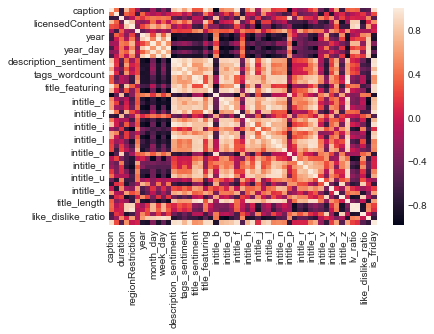

In [76]:
sns.heatmap(df_eng.groupby('view_class').mean().corr())

Observations
* General
 * duration has hump 2-6
 * so does content rating
 * year looks difficult
 * drop year_day, month for week
 * definitely keep description_ text measures
 * drop tags sentiment
* 8/9 vs other
 * tags wordcount possibly confusing 8 vs. 9
* 9 vs other
 * definition is predictor
 * licensed content (but 0 views have lots  of license as well)
 * similar for region restriction
 * month possibly confusing 8/9
 * drop title sentiment, wordcount
 * keep title featuring

Letters yes: a, d, f, g, i, k, l, p, v (kinda), x, y

Looks like value add to drop 0 class